In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [2]:
!ls -lhtr box/frames/

total 8536
-rw-r--r--@ 1 tejaswin.p  1493847943   331K Nov  4  2008 frame_11.png
-rw-r--r--@ 1 tejaswin.p  1493847943   309K Nov  4  2008 frame_10.png
-rw-r--r--@ 1 tejaswin.p  1493847943   313K Nov  4  2008 frame_1.png
-rw-r--r--@ 1 tejaswin.p  1493847943   292K Nov  4  2008 frame_0.png
-rw-r--r--@ 1 tejaswin.p  1493847943   298K Nov  4  2008 frame_7.png
-rw-r--r--@ 1 tejaswin.p  1493847943   297K Nov  4  2008 frame_6.png
-rw-r--r--@ 1 tejaswin.p  1493847943   293K Nov  4  2008 frame_5.png
-rw-r--r--@ 1 tejaswin.p  1493847943   311K Nov  4  2008 frame_4.png
-rw-r--r--@ 1 tejaswin.p  1493847943   310K Nov  4  2008 frame_3.png
-rw-r--r--@ 1 tejaswin.p  1493847943   323K Nov  4  2008 frame_2.png
-rw-r--r--@ 1 tejaswin.p  1493847943   278K Nov  4  2008 frame_13.png
-rw-r--r--@ 1 tejaswin.p  1493847943   326K Nov  4  2008 frame_12.png
-rw-r--r--@ 1 tejaswin.p  1493847943   291K Nov  4  2008 frame_9.png
-rw-r--r--@ 1 tejaswin.p  1493847943   267K Nov  4  2008 frame_8.png


In [3]:
frame = plt.imread('box/frames/frame_0.png')
frame.min(), frame.max()

(0.0627451, 0.99215686)

In [4]:
frame = np.dot(frame[..., :3], [0.333, 0.333, 0.333])

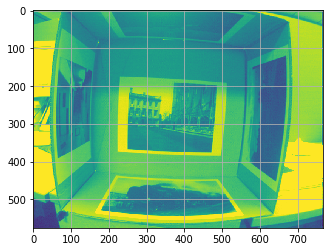

In [5]:
im = plt.imshow(frame)
ax = plt.gca()
ax.grid();

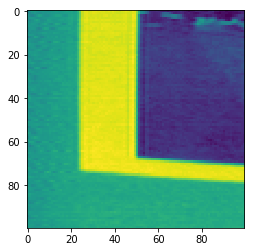

In [6]:
plt.imshow(frame[300:400, 200:300]);

Pixel : 0.8501294206380844
Circle: [0.7835294246077538, 0.5445529682636261, 0.5171294404864312, 0.5092941468358041, 0.654247079372406, 0.8736353015899659, 0.9676588253974915, 0.9754941190481187, 0.9833294126987459, 0.9833294126987459, 0.9754941190481187, 0.9754941190481187, 0.9794117658734323, 0.9872470595240592, 0.9872470595240592, 0.9128117698431015]
Indexd: [0.78352942 0.54455297 0.51712944 0.50929415 0.65424708 0.8736353
 0.96765883 0.97549412 0.98332941 0.98332941 0.97549412 0.97549412
 0.97941177 0.98724706 0.98724706 0.91281177]
True


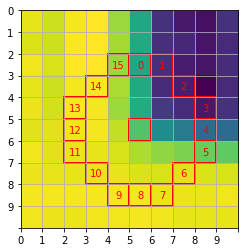

In [28]:
## Approx location -- (365, 250)
section = frame[300:400, 200:300][62:72, 45:55]

im = plt.imshow(section)
ax = plt.gca()

ax.set_xticks(np.arange(-0.5, 10, 1))
ax.set_xticklabels(np.arange(0, 10, 1))

ax.set_yticks(np.arange(-0.5, 10, 1))
ax.set_yticklabels(np.arange(0, 10, 1))

ax.grid();

center = patches.Rectangle((5-0.5,5-0.5),1,1,linewidth=2,edgecolor='r',facecolor='none')
ax.add_patch(center)

v_pix = section[5, 5]
v_xs = []
for num, (ox, oy) in enumerate(circle_mask):
    p = patches.Rectangle((5+ox-0.5, 5+oy-0.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
    v_xs.append(section[5+ox, 5+oy])
    ax.add_patch(p)
    ax.text(5+oy, 5+ox, str(num), ha='center',va='center',color='red')
    
_pixmask = circle_mask + np.array([5, 5])
print "Pixel :", v_pix
print "Circle:", v_xs
print "Indexd:", section[_pixmask[:, 0], _pixmask[:, 1]]
print np.allclose(v_xs, section[_pixmask[:, 0], _pixmask[:, 1]])

Q1. What about the edges which don't have neighbouring pixels?

Since it's only 16 pixels, I guess we can ignore those for now ...

In [23]:
def weak_test(p, compass, t):
    # Higher means brigher.
    if sum([v>=(p+t) for v in compass]) >= 3:  # At least 3 are brighter.
        return True
    elif sum([v<=(p-t) for v in compass]) >= 3:  # At least 3 are darker.
        return True
    else:
        return False

In [62]:
import pdb

In [80]:
def segment_test(p, circle, t):
    vector = []
    for x in circle:
        if x <= (p-t):
            vector.append(-1)
        elif (p-t) < x < (p+t):
            vector.append(0)
        else:
            vector.append(1)

    extended = np.tile(circle, 2)

    for i in range(circle.shape[0]):
        subset = extended[i:i+12]
        if np.alltrue(subset > (p+t)) or np.alltrue(subset < (p-t)):
            return True, vector
        
    return False, vector

In [81]:
from tqdm import tqdm_notebook

In [98]:
# circle_mask = np.array([
#     [ 0, -3],
#    [ 1, -3],
#    [ 2, -2],
#    [ 3, -1],
#    [ 3,  0],
#    [ 3,  1],
#    [ 2,  2],
#    [ 1,  3],
#    [ 0,  3],
#     [-1,  3],
#    [-2,  2],
#    [-3,  1],
#    [-3,  0],
#    [-3, -1],
#    [-2, -2],
#    [-1, -3]
# ])
circle_mask = np.array([
    [-3, 0],
    [-3, 1],
    [-2, 2],
    [-1, 3],
    [0, 3],
    
    [1, 3],
    [2, 2],
    [3, 1],
    [3, 0],
    
    [3, -1],
    [2, -2],
    [1, -3],
    [0, -3],
    
    [-1, -3],
    [-2, -2],
    [-3, -1]
])

compass_mask = [0, 4, 8, 12]

threshold = 0.1

rows, cols = frame.shape[0], frame.shape[1]
potentials = []
trainX, trainY = [], []
for i in tqdm_notebook(range(3, rows - 3)):
    for j in range(3, cols - 3):
        
        pmask = circle_mask + np.array([[i, j]])
        xvals = frame[pmask[:, 0], pmask[:, 1]]
        # compvals = xvals[compass_mask]
        # if weak_test(pval, compvals, threshold):
        
        pval = frame[i, j]
        
        successful, vector = segment_test(pval, xvals, threshold)
        trainX.append(vector)
        if successful is True:
            potentials.append([i, j])
            trainY.append(1)  # This is a corner.
        else:
            trainY.append(0)

In [99]:
len(potentials), len(trainX)

(361, 434340)

In [100]:
rows * cols

442368

In [101]:
import random

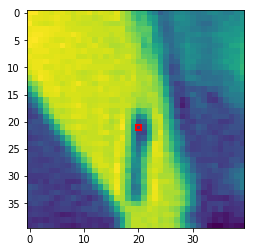

In [191]:
cx, cy = random.choice(potentials)
cpatch = frame[cx-20:cx+20, cy-20:cy+20]
crect = patches.Rectangle((20-0.5, 20+0.5), 1, 1, linewidth=2,edgecolor='r',facecolor='none')
im = plt.imshow(cpatch)
ax = plt.gca()
ax.add_patch(crect);

180 100


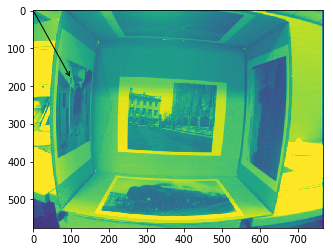

In [192]:
print cx,cy
im = plt.imshow(frame)
ax = plt.gca()
ax.annotate("", xy=(cy, cx), xytext=(0, 0), arrowprops=dict(arrowstyle="->",connectionstyle="arc3"));

In [111]:
pmask

array([[  3, 570],
       [  4, 570],
       [  5, 571],
       [  6, 572],
       [  6, 573],
       [  6, 574],
       [  5, 575],
       [  4, 576],
       [  3, 576],
       [  2, 576],
       [  1, 575],
       [  0, 574],
       [  0, 573],
       [  0, 572],
       [  1, 571],
       [  2, 570]])

In [112]:
cols

768